In [96]:
# library
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate # 교차검증
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
f_path = "C:/Windows/Fonts/malgun.ttf"
rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore")

## 상의 제품정보 data load
- 남여 -> 남
- 남자 : 0 / 여자 : 1로 mapping

In [97]:
df = pd.read_csv('../data/상의/상의 제품정보/(전처리후)musinsa_top_product_v230612.csv'
                 ,encoding="cp949")
df.head(3)

,Unnamed: 0,제품명,브랜드,성별,사이즈,총장,어깨너비,가슴단면,링크,사이즈2,FREESIZE
0,6,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,S,68.5,49.5,53.0,https://www.musinsa.com/app/goods/2034137,S,0
1,7,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,M,70.5,51.5,55.5,https://www.musinsa.com/app/goods/2034137,M,0
2,8,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,L,72.0,53.0,58.0,https://www.musinsa.com/app/goods/2034137,L,0


In [98]:
# 남여 -> 남자
df.loc[df["성별"] == "남여", "성별"] = "남"

### 남성 데이터 

In [99]:
df.성별.value_counts()

남    72796
여    15106
Name: 성별, dtype: int64

In [100]:
df_man = df[df['성별'] == '남']
len(df_man), len(df_man[df_man['브랜드'] == 'MUSINSA STANDARD'])

(72796, 5769)

### 여성 데이터

In [101]:
df_woman = df[df['성별'] == '여']
len(df_woman), len(df_woman[df_woman['브랜드'] == 'MUSINSA STANDARD'])

(15106, 1491)

## 무신사 데이터 추출 및 전처리
- XXL, 2XL 합치기 -> 2XL 정의
- XXXL, 3XL 합치기 ->3XL 정의
- 남자 XS 행 삭제

### 남성 무신사 데이터 

In [102]:
musinsa_man = df_man[df_man["브랜드"] == "MUSINSA STANDARD"]
musinsa_man.drop(["Unnamed: 0"], axis=1, inplace=True)
musinsa_man.shape

(5769, 10)

In [103]:
# 남자 XS 행 삭제 (30개 행 제거)
musinsa_man = musinsa_man.loc[~(musinsa_man["사이즈"] == "XS")]
musinsa_man.shape

(5739, 10)

In [104]:
# XXL, 2XL 합치기 -> 2XL /XXXL, 3XL 합치기 ->3XL 
musinsa_man.loc[musinsa_man["사이즈"] == "XXL", "사이즈"] = "2XL"
musinsa_man.loc[musinsa_man["사이즈"] == "XXXL", "사이즈"] = "3XL"
musinsa_man.사이즈.value_counts()

M      1053
L      1053
XL     1051
2XL    1037
S       928
3XL     617
Name: 사이즈, dtype: int64

In [105]:
# # "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "2XL": 5, "3XL": 6 로 mapping
# musinsa_man["사이즈"] = musinsa_man["사이즈"].map({"XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "2XL": 5, "3XL": 6})
# musinsa_man.사이즈.value_counts().sort_index()

### 여성 무신사 데이터 

In [106]:
musinsa_woman = df_woman[df_woman["브랜드"] == "MUSINSA STANDARD"]
musinsa_woman.drop(["Unnamed: 0"], axis=1, inplace=True)
musinsa_woman.shape

(1491, 10)

In [107]:
# XXL, 2XL 합치기 -> 2XL /XXXL, 3XL 합치기 ->3XL 
musinsa_woman.loc[musinsa_woman["사이즈"] == "XXL", "사이즈"] = "2XL"
musinsa_woman.loc[musinsa_woman["사이즈"] == "XXXL", "사이즈"] = "3XL"

In [108]:
musinsa_woman.사이즈.value_counts()

S     380
M     380
L     370
XS    361
Name: 사이즈, dtype: int64

---

# Model 생성

## RandomForest

## 남성

In [109]:
musinsa_man.shape

(5739, 10)

In [110]:
musinsa_man.columns

Index(['제품명', '브랜드', '성별', '사이즈', '총장', '어깨너비', '가슴단면', '링크', '사이즈2',
       'FREESIZE'],
      dtype='object')

In [111]:
from sklearn.pipeline import Pipeline

# feature, target 분리
X = musinsa_man[['총장', '어깨너비', '가슴단면']]  # 사용할 변수 선택
y = musinsa_man['사이즈']  # 예측할 타겟 변수

# data split (test_size = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=13))]
params1 = {
    'clf__max_depth': [15], 'clf__max_leaf_nodes':[40],
    'clf__min_samples_leaf': [10], 'clf__min_samples_split': [52], 'clf__n_estimators': [100]
}
pipe = Pipeline(estimators)
rf1 = GridSearchCV(estimator=pipe, param_grid=params1, cv=skf)
result_gs = rf1.fit(X_train, y_train)

# GridSearch 결과 확인
cv_results = pd.DataFrame(result_gs.cv_results_)
cv_results[['rank_test_score', 'params', 'mean_test_score']].sort_values("rank_test_score")

,rank_test_score,params,mean_test_score
0,1,"{'clf__max_depth': 15, 'clf__max_leaf_nodes': ...",0.895883


In [112]:
pred = result_gs.predict(X_test)
accuracy_score(y_test, pred)

# cross_validate를 사용하여 모델의 성능 평가
cross_validate(result_gs, X_train, y_train, cv=skf, return_train_score=True)

{'fit_time': array([1.2042017 , 1.19930005, 1.19406199, 1.18868566, 1.19498062]),
 'score_time': array([0.01571655, 0.01597595, 0.01601505, 0.01701498, 0.01629305]),
 'test_score': array([0.89662677, 0.89760349, 0.90196078, 0.89651416, 0.88671024]),
 'train_score': array([0.92320261, 0.91178873, 0.90961067, 0.90933842, 0.91287776])}

In [113]:
# 원본 데이터에 모델 적용
pred_original = result_gs.predict(df_man[['총장', '어깨너비', '가슴단면']])
df_man["pred_size"] = pred_original

In [114]:
df_man.pred_size.value_counts()

L      17870
2XL    15045
S      13597
XL     12055
M      10488
3XL     3741
Name: pred_size, dtype: int64

In [115]:
df_man.to_csv("../data/man_rf.csv", encoding="utf-8")

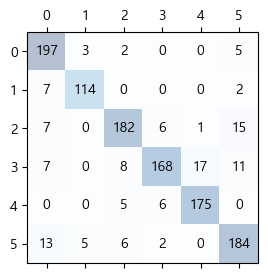

In [116]:
# confusion matrix
conf_mat = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize = (3, 3))
ax.matshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x = j, y = i, s = conf_mat[i, j], va = 'center', ha = 'center')

plt.show()

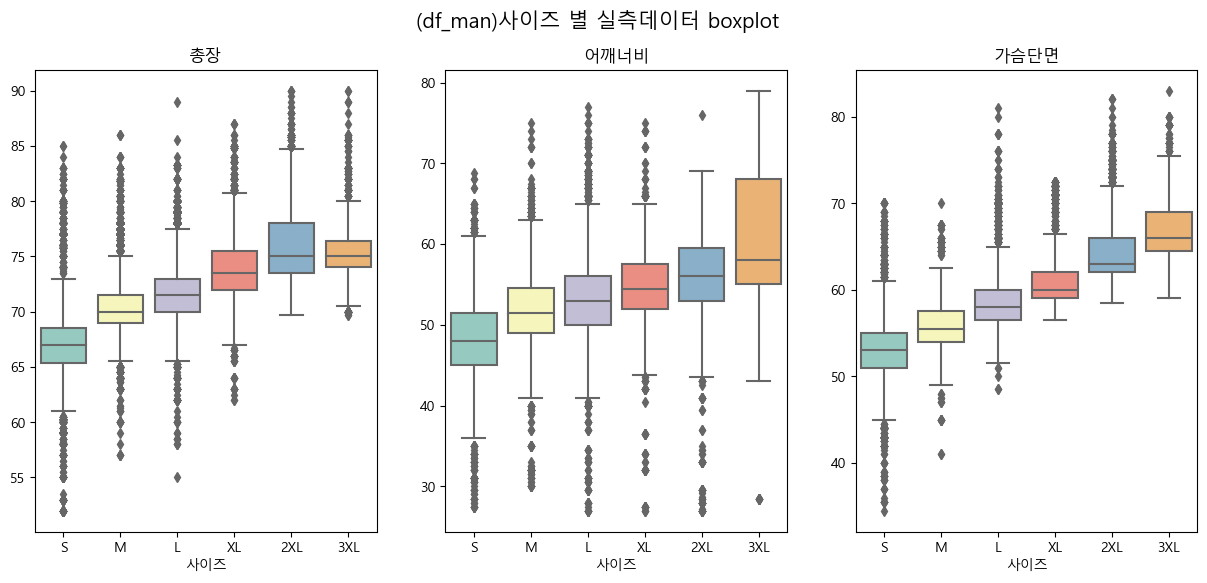

In [117]:
# 사이즈 별 실츠게 데이터 boxplot
sns.set_palette("Set3")
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(df_man, x='pred_size', y='총장', ax=ax[0])
sns.boxplot(df_man, x='pred_size', y='어깨너비', ax=ax[1])
sns.boxplot(df_man, x='pred_size', y='가슴단면', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('사이즈')
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='x')

ax[0].set_title('총장')
ax[1].set_title('어깨너비')
ax[2].set_title('가슴단면')

plt.suptitle('(df_man)사이즈 별 실측데이터 boxplot', fontsize=15)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.show()

### 여성

In [118]:
musinsa_woman.shape

(1491, 10)

In [119]:
# feature, target 분리
X = musinsa_woman[['총장', '어깨너비', '가슴단면']]  # 사용할 변수 선택
y = musinsa_woman['사이즈']  # 예측할 타겟 변수

# data split (test_size = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98, stratify=y)

kfold = KFold(n_splits=5, shuffle=True, random_state=13)
estimators = [('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=13))]

# params = {
#     'clf__max_depth' : [8, 10, 15, 20, 30],
#     'clf__n_estimators' : [100, 150 ,200],
#     'clf__min_samples_leaf': [5, 10, 20, 30, 50],
#     'clf__min_samples_split' : [5, 10, 20, 30],
#     'clf__max_leaf_nodes' : [20, 30, 40, 50, 60, 70, 80, 90]
# }

params = {
    'clf__max_depth': [10], 'clf__max_leaf_nodes':[60],
    'clf__min_samples_leaf': [5], 'clf__min_samples_split': [5], 'clf__n_estimators': [150]
}

pipe = Pipeline(estimators)
rf1 = GridSearchCV(estimator=pipe, param_grid=params, cv=kfold)
result_gs = rf1.fit(X_train, y_train)

# GridSearch 결과 확인
cv_results = pd.DataFrame(result_gs.cv_results_)
cv_results[['rank_test_score', 'params', 'mean_test_score']].sort_values("rank_test_score")


,rank_test_score,params,mean_test_score
0,1,"{'clf__max_depth': 10, 'clf__max_leaf_nodes': ...",0.900207


In [120]:
# cv_results[['rank_test_score', 'params', 'mean_test_score']].sort_values("rank_test_score").to_csv("../data/cv_results_woman.csv"
#                                                                                                    , encoding='utf8')

In [121]:
pred = result_gs.predict(X_test)
accuracy_score(y_test, pred)

# cross_validate를 사용하여 모델의 성능 평가
cross_validate(result_gs, X_train, y_train, cv=skf, return_train_score=True)

{'fit_time': array([1.38133836, 1.37613559, 1.38394284, 1.38593793, 1.36525941]),
 'score_time': array([0.01801682, 0.01501441, 0.01601315, 0.01701427, 0.01501417]),
 'test_score': array([0.87866109, 0.90376569, 0.87394958, 0.90756303, 0.87394958]),
 'train_score': array([0.95487933, 0.94228751, 0.95702306, 0.95073375, 0.95178197])}

In [122]:
# 원본 데이터에 모델 적용
pred_original = result_gs.predict(df_woman[['총장', '어깨너비', '가슴단면']])
df_woman["pred_size"] = pred_original

In [123]:
df_woman.pred_size.value_counts()

L     5058
XS    3538
M     3413
S     3097
Name: pred_size, dtype: int64

In [124]:
# df_woman.to_csv("../data/man_rf.csv", encoding="utf-8")

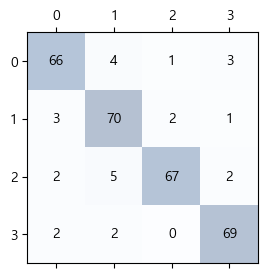

In [125]:
# confusion matrix
conf_mat = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize = (3, 3))
ax.matshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x = j, y = i, s = conf_mat[i, j], va = 'center', ha = 'center')

plt.show()

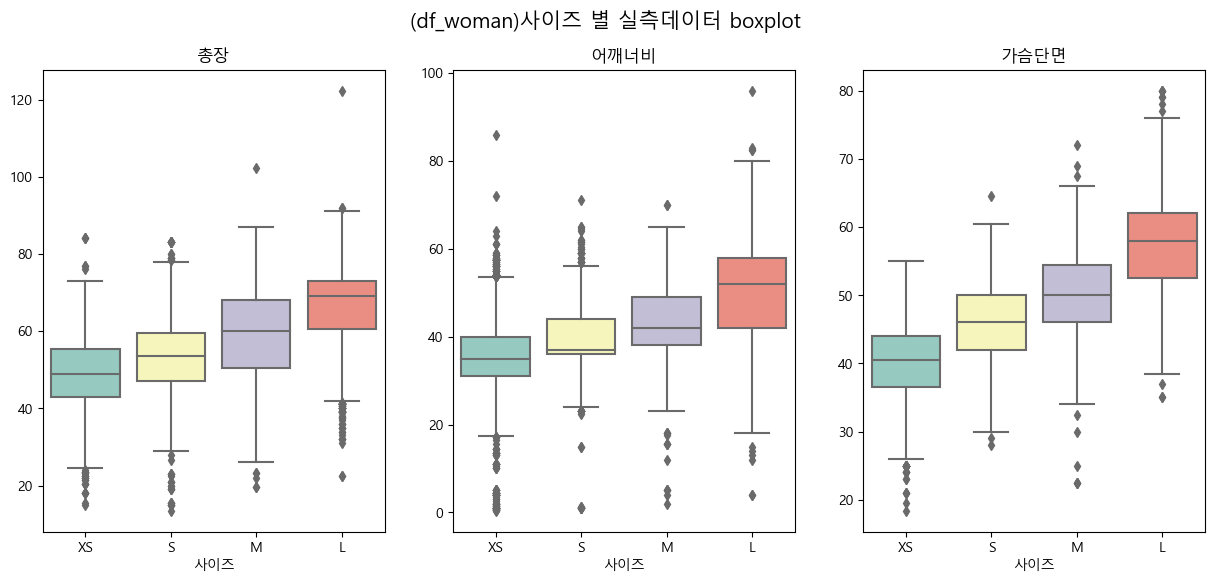

In [126]:
# 사이즈 별 실츠게 데이터 boxplot
sns.set_palette("Set3")
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(df_woman, x='pred_size', y='총장', ax=ax[0])
sns.boxplot(df_woman, x='pred_size', y='어깨너비', ax=ax[1])
sns.boxplot(df_woman, x='pred_size', y='가슴단면', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('사이즈')
    ax[i].set_ylabel('')
    ax[i].tick_params(axis='x')

ax[0].set_title('총장')
ax[1].set_title('어깨너비')
ax[2].set_title('가슴단면')

plt.suptitle('(df_woman)사이즈 별 실측데이터 boxplot', fontsize=15)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.show()

In [130]:
df_final = pd.concat([df_man, df_woman])
df_final.head()

,Unnamed: 0,제품명,브랜드,성별,사이즈,총장,어깨너비,가슴단면,링크,사이즈2,FREESIZE,pred_size
0,6,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,S,68.5,49.5,53.0,https://www.musinsa.com/app/goods/2034137,S,0,S
1,7,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,M,70.5,51.5,55.5,https://www.musinsa.com/app/goods/2034137,M,0,M
2,8,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,L,72.0,53.0,58.0,https://www.musinsa.com/app/goods/2034137,L,0,L
3,9,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,XL,73.5,54.5,60.5,https://www.musinsa.com/app/goods/2034137,XL,0,XL
4,10,릴렉스 핏 크루 넥 반팔 티셔츠 2팩,MUSINSA STANDARD,남,2XL,74.5,56.0,63.0,https://www.musinsa.com/app/goods/2034137,XXL,0,2XL


In [131]:
df_final.to_csv("../data/df_final.csv", encoding='utf-8')